# Generate telluric absorption spectra near 1430 nm for standard terrestrial atmospheric profiles

Tom Schad | 6 March 2024

This notebook uses Py4CAfS to generate telluric absorption spectra near the Si X 1430 nm coronal line. 

The terrestrial atmospheric profile is selected from the standard available in the package. 

The altitude of DKIST is 3067 meters. 


In [175]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob
import sys
import py4cats 
print(py4cats.__file__)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['font.family'] = "serif"
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
from scipy import ndimage

/home/tschad/dkist_telluric_atlas/py4cats/__init__.py


In [177]:
def vac2air(wave_vac):
    """ 
    Converts wavelengths from vacuum to air-equivalent 
    Morton (2000, ApJ. Suppl., 130, 3043); IAU standard

    wave_vac is given in Angstroms
    
    """
    wave_vac = np.atleast_1d(wave_vac)
    wave_air = np.copy(wave_vac)
    ww  = (wave_vac >= 2000) 
    sigma2 = (1e4 / wave_vac[ww])**2 
    n = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wave_air[ww] = wave_vac[ww] / n
    return wave_air

In [154]:
def air2vac(wave_air): 
    """ Converts wavelengths from air-equivalent to vacuum
    Ciddor (1996) formula
    Adapted from airtovac.pro
    wave_air  :: angstroms 
    
    https://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
    
    """
    wave_air = np.atleast_1d(wave_air)
    wave_vac = np.copy(wave_air)
    ww  = (wave_air >= 2000) 
    sigma2 = (1e4 / wave_air[ww])**2 
    n = 1. + 8.336624212083e-5 + 0.02408926869968 / (130.1065924522 - sigma2) + \
        0.0001599740894897 / (38.92568793293 - sigma2)
    wave_vac[ww] = wave_air[ww] * n
    return wave_vac
    

## Set range of wavelengths to use for this notebook

In [139]:
wvAng_min = 14300. - 30.  ## Angstrom
wvAng_max = 14300. + 30.  ## Angstrom
wnMin,wnMax = 1e8/air2vac([wvAng_max,wvAng_min])
print('range of wavenumbers [cm^-1] ',wnMin,'  ',wnMax)

range of wavenumbers [cm^-1]  6976.4598800932    7005.793234004564


In [140]:
hitran_data_file = './HITRAN_VIS_IR/65e912c9.par'

## Load different terrestial atmospheres for comparison 

Here we load standard terrestrial atmosphere profiles to compare their structure and some select molecular concentrations

In [141]:
atmos = 'USstandard_main','subarcticWinter','subarcticSummer','midlatitudeWinter','midlatitudeSummer','tropical',

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels


Text(0.5, 0.98, 'Comparison of Reference Atmospheric Profiles')

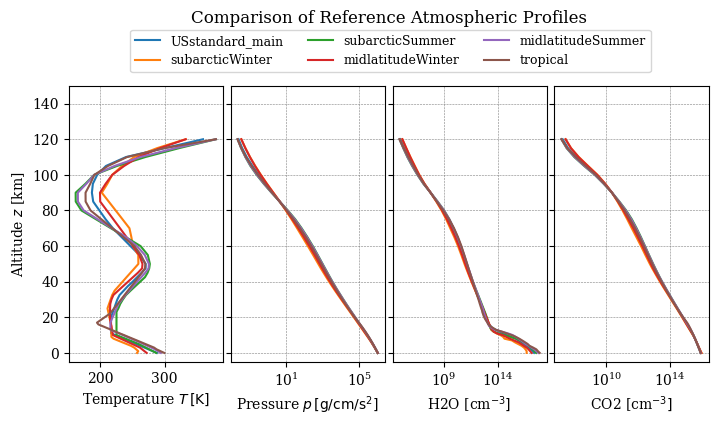

In [142]:
fig,ax = plt.subplots(1,4,figsize = (8,4),sharey=True)
ax = ax.flatten()

for n in range(len(atmos)): 
    
    atmDat = py4cats.atmRead('./py4cats/data/atmos/50/' + atmos[n] + '.xy')
    
    ## plot z vs T
    plt.sca(ax[0])
    py4cats.atmPlot(atmDat,label = atmos[n])
    
    ## plot z vs P
    plt.sca(ax[1])
    py4cats.atmPlot(atmDat,'p',label = atmos[n])
    ax[1].set_xscale('log')

    ## plot h20 and c02 content 
    main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
    for mm in range(2): 
        plt.sca(ax[mm+2])
        py4cats.atmPlot(atmDat,main_mol[mm],label = atmos[n])
        ax[mm+2].set_xscale('log')
    
    ax[3].legend(loc = (-2.75,1.05),fontsize =9,ncol =3)
    ax[0].set_ylim(-5,150)
    for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')
    for axi in ax[1:]:  axi.set_ylabel('')
        
fig.subplots_adjust(0.1,0.1,0.9,0.79,wspace=0.05)
fig.suptitle('Comparison of Reference Atmospheric Profiles',fontsize = 12)


## Now do a finer comparison of 2 atmospheres -- midlatitudewinter and USstandard

In [143]:
atm_midLatWinter = py4cats.atmRead('./py4cats/data/atmos/50/midlatitudeWinter.xy')
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  

 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p, T, air   and 7 molecules on 50 levels


In [144]:
#REGRIDDING THE LOWER PORTION OF THE PROFILE FOR FINER SAMPLING 
znew = np.hstack((py4cats.parseGridSpec('0[0.1]7'),atm_midLatWinter['z'][8:]/1e5))
print(' Number of grid layers in regridded atmospheres: ',znew.shape)
atm_midLatWinter = py4cats.atmRegrid(atm_midLatWinter,znew*1e5)
atm_standard  = py4cats.atmRegrid(atm_standard,znew*1e5)

 Number of grid layers in regridded atmospheres:  (113,)
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)


In [145]:
print(' Height index,  z [km] ,  P (atm) ,  T (K)')
for n in range(10): 
    print('        ',n,'    ', np.round(atm_midLatWinter['z'][n]/1e5,2),'      ',
          np.round(atm_midLatWinter['p'][n]/1000.*100./101325.,2),'     ',np.round(atm_midLatWinter['T'][n],2))

 Height index,  z [km] ,  P (atm) ,  T (K)
         0      0.0        1.0       272.2
         1      0.1        0.99       271.85
         2      0.2        0.98       271.5
         3      0.3        0.97       271.15
         4      0.4        0.96       270.8
         5      0.5        0.94       270.45
         6      0.6        0.93       270.1
         7      0.7        0.92       269.75
         8      0.8        0.91       269.4
         9      0.9        0.9       269.05


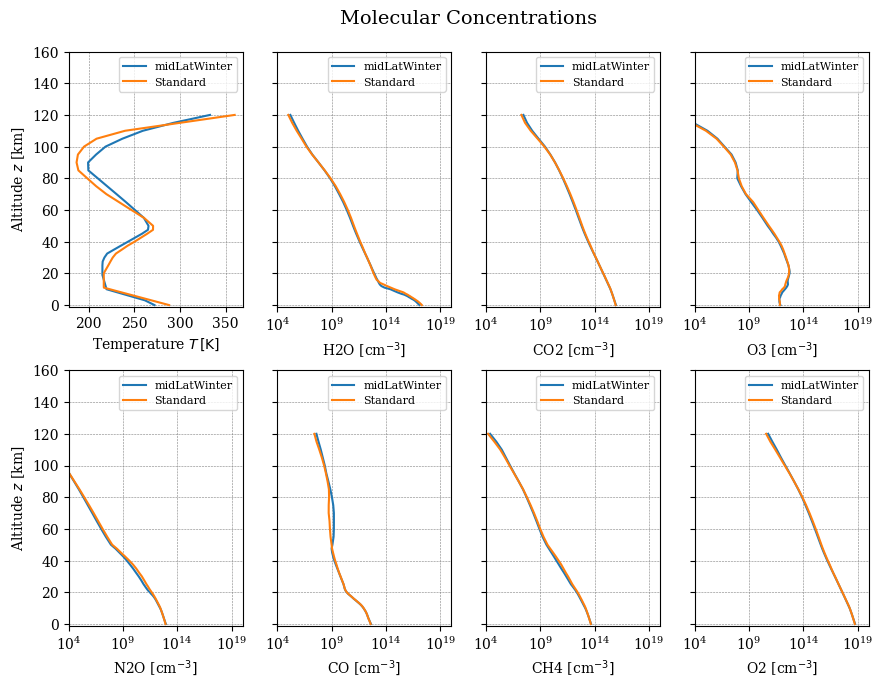

In [146]:
fig,ax = plt.subplots(2,4,figsize = (10,7),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
py4cats.atmPlot(atm_midLatWinter,label = 'midLatWinter')
py4cats.atmPlot(atm_standard,label = 'Standard')
ax[0].legend(loc = 'upper right',fontsize = 8)

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    py4cats.atmPlot(atm_midLatWinter,main_mol[n-1],label = 'midLatWinter')
    py4cats.atmPlot(atm_standard,main_mol[n-1],label = 'Standard')
    ax[n].set_xscale('log')
    ax[n].legend(loc = 'upper right',fontsize = 8)
    
ax[0].set_ylim(-1,160)

for n in range(1,8): 
    ax[n].set_xlim(1e4,1e20)
for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')
for axi in ax[1:4]:  axi.set_ylabel('')
for axi in ax[5:]:  axi.set_ylabel('')

fig.suptitle("Molecular Concentrations",fontsize = 14) 
fig.subplots_adjust(0.1,0.1,0.9,0.92,wspace=0.2,hspace = 0.25)

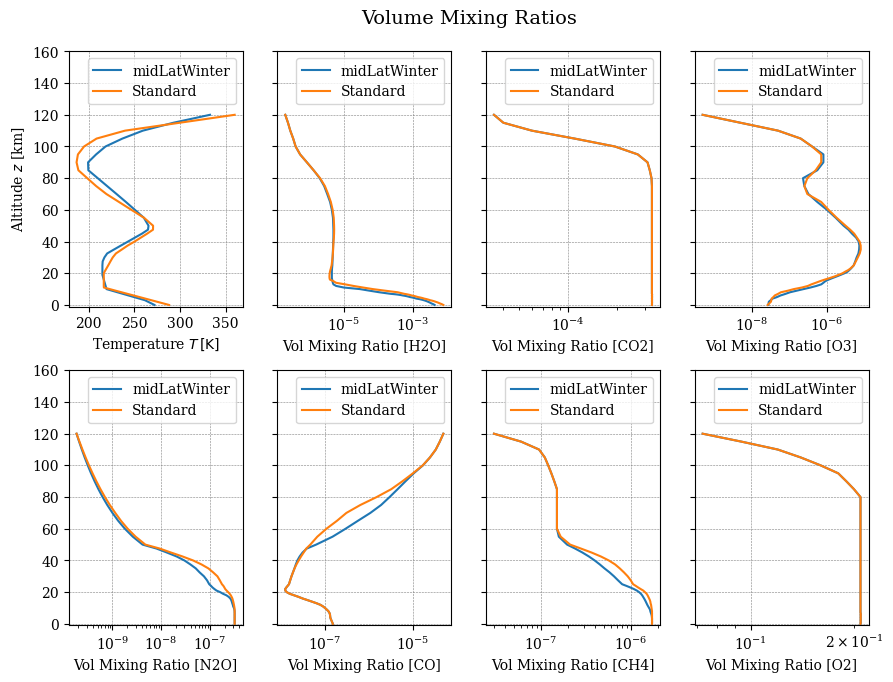

In [147]:
fig,ax = plt.subplots(2,4,figsize = (10,7),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
py4cats.atmPlot(atm_midLatWinter,label = 'midLatWinter')
py4cats.atmPlot(atm_standard,label = 'Standard')
ax[0].legend(fontsize=10)

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    plt.plot(py4cats.vmr(atm_midLatWinter,main_mol[n-1]),atm_midLatWinter['z']/1e5,label = 'midLatWinter')
    plt.plot(py4cats.vmr(atm_standard,main_mol[n-1]),atm_standard['z']/1e5,label = 'Standard')
    plt.xscale('log')
    plt.xlabel('Vol Mixing Ratio ['+main_mol[n-1] + ']')
    ax[n].legend(loc = 'upper right',fontsize=10)
    
ax[0].set_ylim(-1,160)
for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')
for axi in ax[1:4]:  axi.set_ylabel('')
for axi in ax[5:]:  axi.set_ylabel('')
fig.suptitle("Volume Mixing Ratios",fontsize = 14) 
fig.subplots_adjust(0.1,0.1,0.9,0.92,wspace=0.2,hspace = 0.25)

## Get vertical column densities [molec / cm**2 ] 

In [148]:
for mol in 'H2O','N2O','CO2',: 
    print('----- Molecule: ',mol)
    print(f"Vertical column density in midLatWinter (full atmosphere): {py4cats.vcd(atm_midLatWinter,mol,zMin = 0.0)}") 
    print(f"Vertical column density in midLatWinter (above 3km): {py4cats.vcd(atm_midLatWinter,mol,zMin = 3.0)}") 
    print(f"Vertical column density in US standard (full atmosphere): {py4cats.vcd(atm_standard,mol,zMin = 0.0)}") 
    print(f"Vertical column density in US standard  (above 3km): {py4cats.vcd(atm_standard,mol,zMin = 3.0)}") 

----- Molecule:  H2O
Vertical column density in midLatWinter (full atmosphere): 2.8906793192153e+22
Vertical column density in midLatWinter (above 3km): 6.689164304859454e+21
Vertical column density in US standard (full atmosphere): 4.808953629516041e+22
Vertical column density in US standard  (above 3km): 1.1474288295160398e+22
----- Molecule:  N2O
Vertical column density in midLatWinter (full atmosphere): 6.46984417129518e+18
Vertical column density in midLatWinter (above 3km): 4.265045201107645e+18
Vertical column density in US standard (full atmosphere): 6.62199191379642e+18
Vertical column density in US standard  (above 3km): 4.5015119137964196e+18
----- Molecule:  CO2
Vertical column density in midLatWinter (full atmosphere): 7.151195964449711e+21
Vertical column density in midLatWinter (above 3km): 4.877497026443813e+21
Vertical column density in US standard (full atmosphere): 7.118266103760752e+21
Vertical column density in US standard  (above 3km): 4.931521103760752e+21


In [149]:
print(' Column Mixing Ratios: ')
for mol in main_mol: 
    print(mol,': ',py4cats.cmr(atm_standard,mol),' ',py4cats.cmr(atm_midLatWinter,mol))

 Column Mixing Ratios: 
H2O :  0.0022305755912426202   0.0013347922335154915
CO2 :  0.0003301722546369477   0.0003302116831238814
O3 :  4.308899652075879e-07   4.7080394840993804e-07
N2O :  3.0715317023771747e-07   2.987497677274201e-07
CO :  1.1096299619118793e-07   1.1200916736041277e-07
CH4 :  1.6483812464617394e-06   1.5915415790250604e-06
O2 :  0.2091091150936424   0.20913409169086775


##  Calculate precipitable water
* mass density of water is ~ 0.9998 g cm^-3
* average molar mass of water is 18.01528 g/mol
* Na = 6.022e23

In [150]:
# V = rho * h * Na / M 
rho = 0.9998  # g/cm**3
Na = 6.022e23 # molec / mole 
M = 18.01528 # g / mole 

V = py4cats.vcd(atm_midLatWinter,'H2O',zMin = 0.0)
print(V)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [midLatWinter]')

V = py4cats.vcd(atm_standard,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [standard]')

2.8906793192153e+22
8.64942123693304  millimeters PWV [midLatWinter]
14.389235559291825  millimeters PWV [standard]


## Here we start to work with the HITRAN Database to calculate the telluric absorption spectra

### Load Line List

In [169]:
dictOfLineLists = py4cats.higstract(hitran_data_file,(wnMin,wnMax),molecule = 'main')

# first line in spectral range at record number 1038067 found in 7051215.531739909 sec
 b' 11 6976.460706 1.773E-30 8.918E-01.07720.371 4296.56340.650.001140'
# last  line     accepted 
 b' 61 7005.782900 3.471E-24 0.000E+00.05370.070  562.74000.64-.014000'
# first line not accepted 
 b' 21 7005.793403 7.499E-30 8.281E-05.08220.112 1954.35140.68-.007062'
 main gases only:  deleted  0  of  5  molecules in dict of linelists with originally 2824 lines

 2824 lines of  5  molecule(s) extracted from  ./HITRAN_VIS_IR/65e912c9.par
 returning a dictionary of lineArray's for  H2O O3 CH4 CO2 N2O


### Print strongest three lines of each molecule in line list

In [170]:
print('MOL___VMIN_______VMAX_______NUM LINES')
for k in dictOfLineLists.keys(): 
    print(k,' ',dictOfLineLists[k]['v'].min(),dictOfLineLists[k]['v'].max(),len(dictOfLineLists[k]))
    wvair = vac2air((1e7/dictOfLineLists[k]['v'])*10)/10.
    strength = dictOfLineLists[k]['S']
    smax = np.flip(np.argsort(strength))
    print('____  WNUM _______ WVAIR NM ____  STRENGTH (cm^-1 / (molecule cm^-2))')
    for ll in range(3): 
        print(' --- ',ll,' ',dictOfLineLists[k]['v'][smax[ll]],wvair[smax[ll]],strength[smax[ll]])
    print(wvair[np.argmax(dictOfLineLists[k]['S'])])

MOL___VMIN_______VMAX_______NUM LINES
H2O   6976.460706 7005.74819 1269
____  WNUM _______ WVAIR NM ____  STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6981.112471 1432.0449698655698 1.071e-21
 ---  1   6987.144435 1430.808691328904 8.511e-22
 ---  2   6993.263186 1429.5568043242824 6.637e-22
1432.0449698655698
O3   6976.4721 6996.6808 464
____  WNUM _______ WVAIR NM ____  STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6995.4886 1429.1020311542027 2.343e-27
 ---  1   6996.297 1428.9369026832017 2.323e-27
 ---  2   6995.3608 1429.1281398168635 2.31e-27
1429.1020311542027
CH4   6976.5067 7005.7829 822
____  WNUM _______ WVAIR NM ____  STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6995.6376 1429.0715926814999 2.336e-23
 ---  1   6995.8148 1429.0353950582353 2.023e-23
 ---  2   6996.4571 1428.9042042559372 1.439e-23
1429.0715926814999
CO2   6976.745778 7005.712866 155
____  WNUM _______ WVAIR NM ____  STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6983.01903 1431.653981051204 5.988e-23
 --- 

## Bar graphs of all lines and there line strengths

5


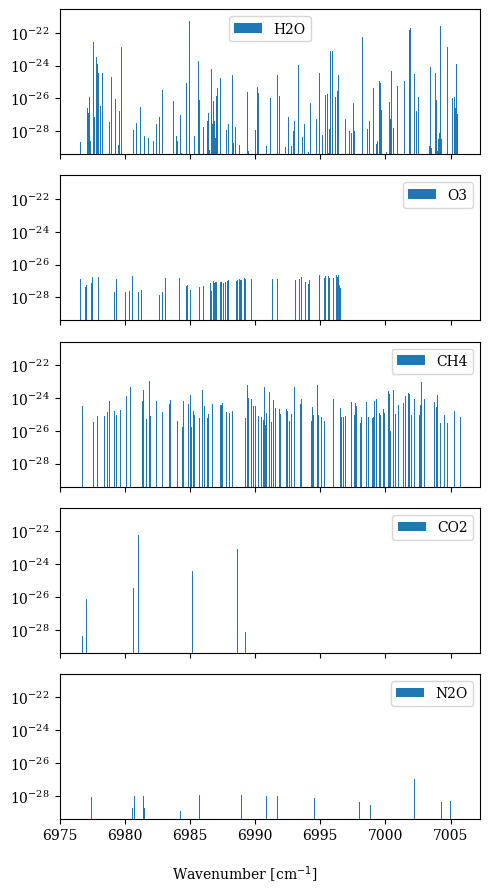

In [191]:
nmol = len(dictOfLineLists.keys())
print(nmol)
fig,ax = plt.subplots(nmol,1,figsize = (5,9),sharex=True,sharey=True)

for n,k in enumerate(dictOfLineLists.keys()): 
    ax[n].bar(dictOfLineLists[k]['v'],dictOfLineLists[k]['S'],width = 0.01,label = k)
    ax[n].legend()

ax[0].set_yscale('log')
fig.supxlabel(r'Wavenumber [cm$^{-1}$]')
fig.tight_layout()

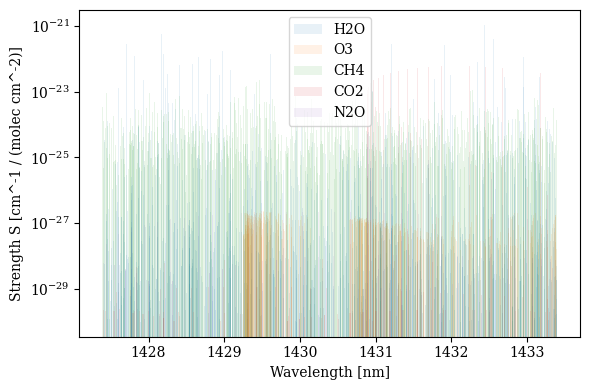

In [184]:
plt.figure(figsize = (6,4))
for k in dictOfLineLists.keys(): 
    plt.bar(1e7/dictOfLineLists[k]['v'],dictOfLineLists[k]['S'],width = 0.01,label = k,alpha = 0.1)
plt.yscale('log')
plt.legend()
plt.ylabel('Strength S [cm^-1 / (molec cm^-2)]')
plt.xlabel('Wavelength [nm]')
plt.tight_layout()

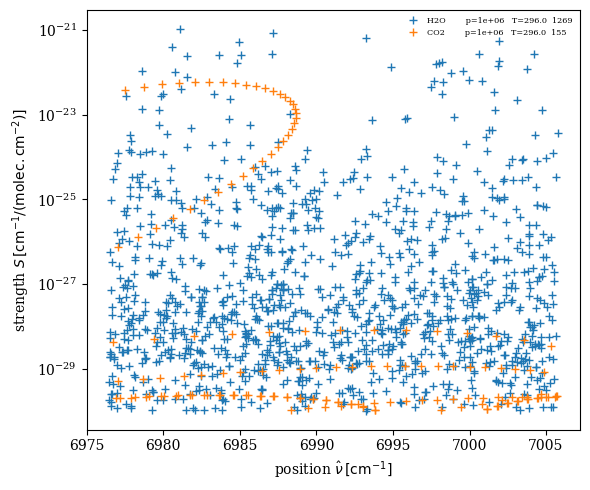

In [193]:
plt.figure(figsize = (6,5))
py4cats.atlas(dictOfLineLists['H2O'],yType = 'S')
py4cats.atlas(dictOfLineLists['CO2'],yType = 'S')
plt.tight_layout()

In [194]:
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  ## Ammonia wasn't really that important
znew = np.hstack((py4cats.parseGridSpec('0[0.1]7'),atm_standard['z'][8:]/1e5))
atm_standard  = py4cats.atmRegrid(atm_standard,znew*1e5)
atm_standard['CO2'] = atm_standard['CO2'] * 1.92
atm_standard['H2O'] = atm_standard['H2O'] * 0.48
atmDat = atm_standard

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)


## Get absorption cross sections

In [195]:
xssDict = py4cats.lbl2xs(dictOfLineLists, atmDat['p'], atmDat['T'],(6979,7001))


 lbl2xs:  H2O       18.02amu 1269 lines @ reference p [g/cm/s**2]  1.013e+06      T [K] 296.00  ---> 113 p,T pairs 
 cross section  H2O       1269 lines      1013mb  288.2K        1601      0.36sec   175.61ns:  8.10425e-24 < xs < 4.14042e-21
 cross section  H2O       1269 lines   1000.96mb  287.6K        1601      0.35sec   173.16ns:  8.01384e-24 < xs < 4.17693e-21
 cross section  H2O       1269 lines   989.054mb  286.9K        1665      0.35sec   167.29ns:  7.92175e-24 < xs < 4.21745e-21
 cross section  H2O       1269 lines   977.295mb  286.2K        1665      0.35sec   164.60ns:  7.83351e-24 < xs < 4.25344e-21
 cross section  H2O       1269 lines   965.675mb  285.6K        1665      0.34sec   163.23ns:  7.74627e-24 < xs < 4.28959e-21
 cross section  H2O       1269 lines   954.193mb  284.9K        1729      0.35sec   161.11ns:  7.65583e-24 < xs < 4.33629e-21
 cross section  H2O       1269 lines   942.848mb  284.3K        1729      0.35sec   160.16ns:  7.57047e-24 < xs < 4.37359e-21
 

## Absorption coefficients 

In [196]:
absCoList = py4cats.xs2ac(atmDat, xssDict) 


 INFO --- xs2ac:  atmosphere with  113  levels with  7  molecules  H2O CO2 O3 N2O CO CH4 O2       but  2  of 7  gases without cross sections!

 INFO --- xs2ac:  wavenumber limits identical for all xs:   6979.0 <= v <= 7001.0
    0     0.00km             1857 points    <ac> =   2.8e-05      7.83e-07 < ac <  0.000393  @ 6987.131466cm-1
    1     0.10km             1857 points    <ac> =  2.72e-05      7.53e-07 < ac <  0.000385  @ 6987.131466cm-1
    2     0.20km             1921 points    <ac> =  2.63e-05      7.22e-07 < ac <  0.000378  @ 6987.135417cm-1
    3     0.30km             1921 points    <ac> =  2.54e-05      6.92e-07 < ac <   0.00037  @ 6987.135417cm-1
    4     0.40km             1921 points    <ac> =  2.46e-05      6.63e-07 < ac <  0.000361  @ 6987.135417cm-1
    5     0.50km             1985 points    <ac> =  2.37e-05      6.35e-07 < ac <  0.000352  @ 6987.139113cm-1
    6     0.60km             1985 points    <ac> =  2.29e-05      6.07e-07 < ac <  0.000343  @ 6987.139113cm

In [197]:
absCoList[0].info()

air H2O O3 CH4 CO2 N2O     0.0km  1.013e+03mb  288.2K             1857 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   7.8e-07 < ac <  0.00039


113


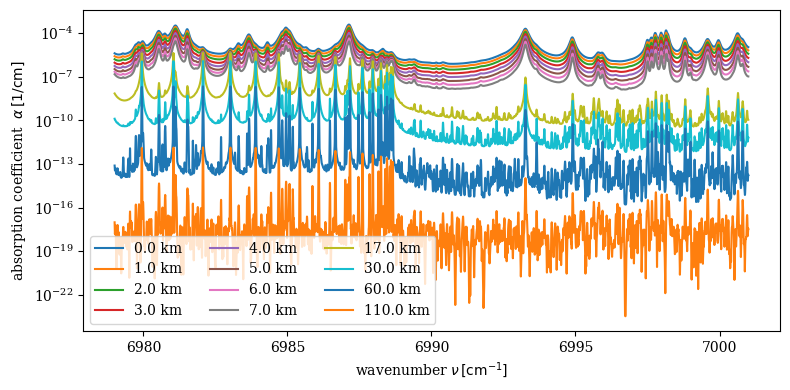

In [198]:
plt.figure(figsize = (8,4))
xUnit='1/cm'
plt.ylabel(r'absorption coefficient  $\alpha \rm\,[1/cm]$')
plt.xlabel(r'wavenumber $\nu \rm\,[cm^{-1}]$')
print(len(absCoList))
for n in range(0,len(absCoList),10): 
    plt.plot(absCoList[n].grid(),absCoList[n],label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')
plt.yscale('log')
plt.legend(ncol = 3)
plt.tight_layout()

## Optical Depth 

In [200]:
## change the airmass for a slant geometry 
dodList = py4cats.ac2dod(absCoList)
airmass = 1. ## 1/np.cos(zenith_angle)  == 2 @ 60 deg 
for n in range(len(dodList)): 
    dodList[n] = dodList[n]*airmass  ## airmass

air H2O O3 CH4 CO2 N2O     0.0km  1.013e+03mb  288.2K             1857 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   7.8e-07 < ac <  0.00039
air H2O O3 CH4 CO2 N2O     0.1km  1.001e+03mb  287.6K             1857 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   7.5e-07 < ac <  0.00039
air H2O O3 CH4 CO2 N2O     0.2km  9.891e+02mb  286.9K             1921 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   7.2e-07 < ac <  0.00038
air H2O O3 CH4 CO2 N2O     0.3km  9.773e+02mb  286.2K             1921 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   6.9e-07 < ac <  0.00037
air H2O O3 CH4 CO2 N2O     0.4km  9.657e+02mb  285.6K             1921 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   6.6e-07 < ac <  0.00036
air H2O O3 CH4 CO2 N2O     0.5km  9.542e+02mb  284.9K             1985 wavenumbers in  6979.000000 ... 7001.000000 cm-1  with   6.4e-07 < ac <  0.00035
air H2O O3 CH4 CO2 N2O     0.6km  9.428e+02mb  284.3K             1985 wavenumbers in  6

In [201]:
codList = py4cats.dod2cod(dodList,True)  ## cummulative od 

In [202]:
tod = py4cats.dod2tod(dodList)  ## total od 

In [203]:
print(len(codList))

112


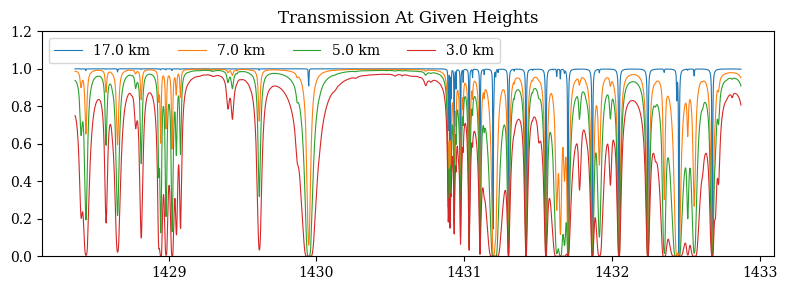

In [204]:
plt.figure(figsize = (8,3))

for n in 80,70,50,30,: 
    plt.plot(1e7/codList[n].grid(),np.exp(-codList[n]),lw = 0.8,label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')

plt.legend(loc = 'upper left',ncol = 4)
plt.ylim(0.,1.2)
plt.title('Transmission At Given Heights')
plt.tight_layout()

## Do the above for different molecules 

In [242]:
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  ## Ammonia wasn't really that important
znew = np.hstack((py4cats.parseGridSpec('0[0.1]7'),atm_standard['z'][8:]/1e5))
atm_standard  = py4cats.atmRegrid(atm_standard,znew*1e5)
atm_standard['CO2'] = atm_standard['CO2'] * 1.26  ## scaled to 11 Dec 2023 -  417 ppm 
atm_standard['H2O'] = atm_standard['H2O'] 
atmDat = atm_standard

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)


In [243]:
print(f"Vertical column density in US standard  (above 3km): {py4cats.cmr(atm_standard,'H2O',zMin = .0)}") 
print(f"Vertical column density in US standard  (above 3km): {py4cats.cmr(atm_standard,'CO2',zMin = .0)}") 

Vertical column density in US standard  (above 3km): 0.0022305755912426202
Vertical column density in US standard  (above 3km): 0.00041601704084255403


In [244]:
V = py4cats.vcd(atm_standard,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [standard]')

14.389235559291825  millimeters PWV [standard]


In [245]:
main_mol

('H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2')

In [247]:
absCoList = py4cats.xs2ac(atmDat, xssDict)    ## recalculate for changes in molecular densities (xssDict ar the cross-sections for different p and T 
dodList = py4cats.ac2dod(absCoList)
codList_all = py4cats.dod2cod(dodList,True)  ## cummulative od 


 INFO --- xs2ac:  atmosphere with  113  levels with  7  molecules  H2O CO2 O3 N2O CO CH4 O2       but  2  of 7  gases without cross sections!

 INFO --- xs2ac:  wavenumber limits identical for all xs:   6979.0 <= v <= 7001.0
    0     0.00km             1857 points    <ac> =  5.77e-05      1.61e-06 < ac <  0.000816  @ 6987.131466cm-1
    1     0.10km             1857 points    <ac> =  5.59e-05      1.55e-06 < ac <  0.000799  @ 6987.131466cm-1
    2     0.20km             1921 points    <ac> =  5.41e-05      1.48e-06 < ac <  0.000784  @ 6987.135417cm-1
    3     0.30km             1921 points    <ac> =  5.23e-05      1.42e-06 < ac <  0.000766  @ 6987.135417cm-1
    4     0.40km             1921 points    <ac> =  5.05e-05      1.36e-06 < ac <  0.000749  @ 6987.135417cm-1
    5     0.50km             1985 points    <ac> =  4.88e-05       1.3e-06 < ac <   0.00073  @ 6987.139113cm-1
    6     0.60km             1985 points    <ac> =   4.7e-05      1.25e-06 < ac <  0.000711  @ 6987.139113cm

In [248]:
airmass = 1.5 ## 1/np.cos(np.deg2rad(45.)) ## 1/np.cos(zenith_angle)  == 2 @ 60 deg , 4 @ 75. 
print(airmass)
for n in range(len(dodList)): 
    dodList[n] = dodList[n]*airmass  ## airmass
codList_all_airmass = py4cats.dod2cod(dodList,True)  ## cummulative od 

1.5


In [249]:
cods = []
cods_mol = []
cods_airmass = []

airmass = 1.5 ## 1/np.cos(zenith_angle)  == 2 @ 60 deg , 4 @ 75. 
print(airmass)

for mol in main_mol: 
    print(mol)
    try: 
        absCoList = py4cats.xs2ac(atmDat, xssDict[mol])    ## absorption coefficients for a single molecule 
        dodList = py4cats.ac2dod(absCoList)
        codList = py4cats.dod2cod(dodList,True)  ## cummulative od 
        cods_mol.append(mol)
        cods.append(codList)
        
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]*airmass  ## airmass
            
        codList = py4cats.dod2cod(dodList,True)  ## cummulative od 
        cods_airmass.append(codList)

    except:
        print('failed')        

1.5
H2O
INFO --- xs2ac:  got a list of xsArray's for  H2O ,    packed into a dictionary

 INFO --- xs2ac:  atmosphere with  113  levels with  7  molecules  H2O CO2 O3 N2O CO CH4 O2       but  6  of 7  gases without cross sections!

 INFO --- xs2ac:  wavenumber limits identical for all xs:   6979.0 <= v <= 7001.0
    0     0.00km             1601 points    <ac> =  5.73e-05       1.6e-06 < ac <  0.000817  @ 6987.140000cm-1
    1     0.10km             1601 points    <ac> =  5.55e-05      1.54e-06 < ac <  0.000801  @ 6987.140000cm-1
    2     0.20km             1665 points    <ac> =  5.38e-05      1.47e-06 < ac <  0.000784  @ 6987.131010cm-1
    3     0.30km             1665 points    <ac> =   5.2e-05      1.41e-06 < ac <  0.000767  @ 6987.131010cm-1
    4     0.40km             1665 points    <ac> =  5.02e-05      1.35e-06 < ac <  0.000749  @ 6987.131010cm-1
    5     0.50km             1729 points    <ac> =  4.85e-05      1.29e-06 < ac <  0.000732  @ 6987.135417cm-1
    6     0.60km    

In [250]:
len(cods),len(cods_airmass),len(cods_mol),cods_mol

(5, 5, 5, ['H2O', 'CO2', 'O3', 'N2O', 'CH4'])

In [251]:
main_mol

('H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2')

## Load the Pseudo solar spectra

In [252]:
# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
dc = np.loadtxt('/home/tschad/cryo_reductions/SiX_March_2022/HITRAN_LineFits/solar_merged_20200720_600_33300_000.out',skiprows =3)  ## disk center -- 000
dcwv = vac2air(1e7/dc[:,0]*10)/10.
dcsp = dc[:,1]
ww = (dcwv >1427.5)*(dcwv < 1432)
dcwv = dcwv[ww][::-1]
dcsp = dcsp[ww][::-1]

# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
di = np.loadtxt('/home/tschad/cryo_reductions/SiX_March_2022/HITRAN_LineFits/solar_merged_20200720_600_33300_100.out',skiprows =3)  ## disk integrated -- 100
diwv = vac2air(1e7/di[:,0]*10)/10.
disp = di[:,1]
ww = (diwv >1427.5)*(diwv < 1432)
diwv = diwv[ww][::-1]
disp = disp[ww][::-1]

## Read the FTS atlas for plotting

In [253]:
from  scipy.io import readsav
idld = readsav('/home/tschad/cnSAT/combined_fts_atlases_2898A_54097A.sav')
ftswv    = np.copy(idld['lambda_angstrom']) /10.   ## nm 
ftsatm   = np.copy(idld['atm_absorption'])
ftscor   = np.copy(idld['corrected_flux'])
ftsobs   = np.copy(idld['observed_flux'])

In [254]:
wh = np.argmin(np.abs(atmDat['z'] - 3.e5))
#wh = np.argmin(np.abs(atmDat['z'] - 2.e5))  ## ~ kitt peak
print(wh)

30


In [255]:
wv = vac2air(1e7/codList_all[0].grid()*10.)/10.

In [256]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [257]:
len(atmDat['z'])

113

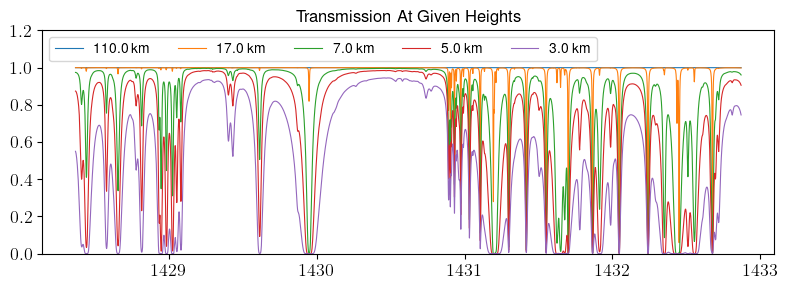

In [267]:
plt.figure(figsize = (8,3))

for n in 110,80,70,50,30,: 
    plt.plot(vac2air(1e7/codList_all[n].grid()),np.exp(-codList_all[n]),lw = 0.8,label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')

plt.legend(loc = 'upper left',ncol = 5)
plt.ylim(0.,1.2)
plt.title('Transmission At Given Heights')
plt.tight_layout()


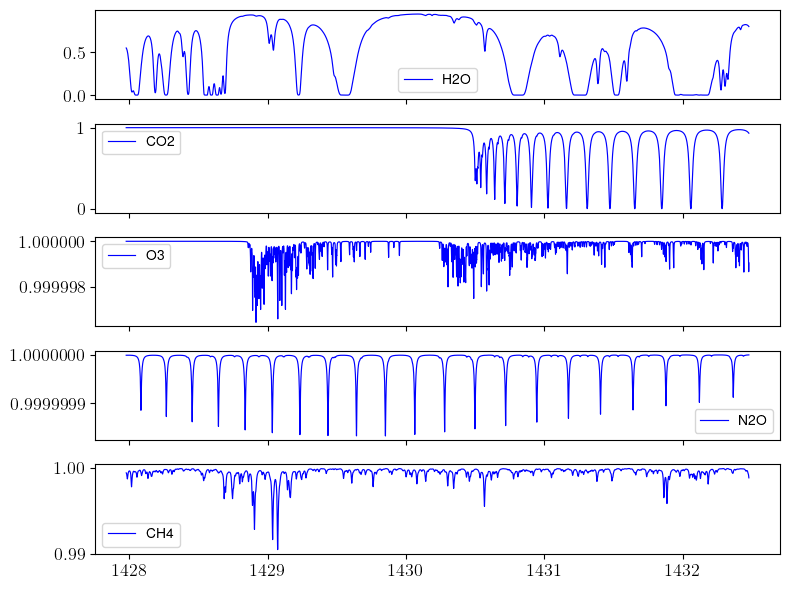

In [268]:
fig,ax = plt.subplots(5,1,figsize = (8,6),sharex=True)
ax = ax.flatten()

for n in range(len(cods)): 
    wv = vac2air(1e7/cods[n][wh].grid()*10.)/10.
    ax[n].plot(wv,np.exp(-cods[n][wh]),'b',lw = 0.85,label = cods_mol[n])
    ax[n].legend()
    ax[n].get_yaxis().get_major_formatter().set_useOffset(False)
fig.tight_layout()


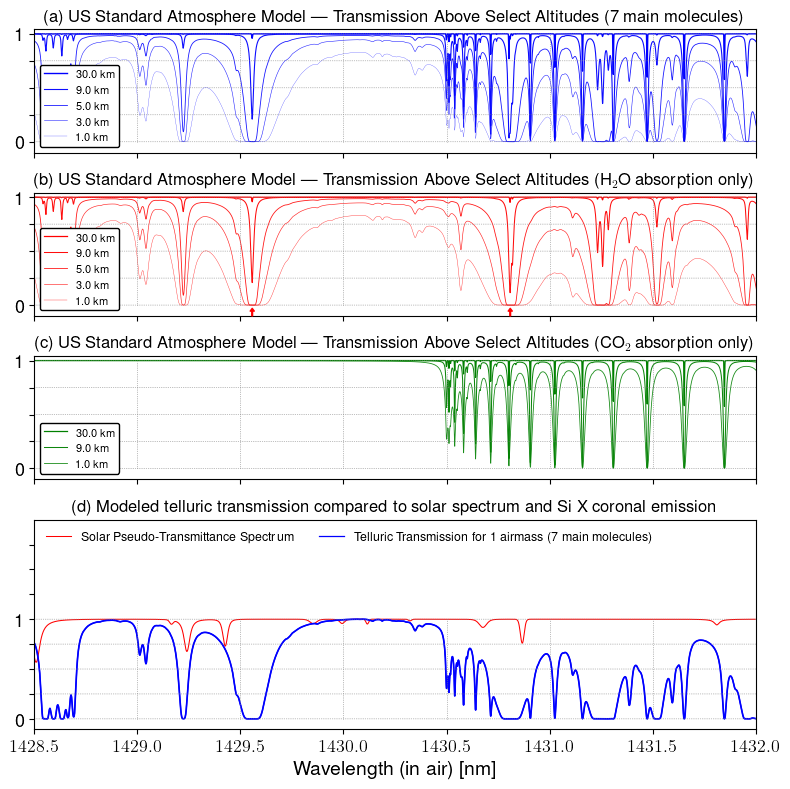

In [265]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig,ax = plt.subplots(4,1,figsize = (8.,8.),sharex=True,sharey=False,height_ratios = [1,1,1,1.7])
ax = ax.flatten()

n = 0
wv = vac2air(1e7/codList_all[0].grid()*10.)/10.
ax[0].set_xlim(wv.min(),wv.max())

aa = 1.
th = 1.
for hh in 90,72,50,30,10,: 
    ax[n].plot(wv,np.exp(-codList_all[hh]),label = str(np.round(atmDat['z'][hh]/1e5,2)) + ' km',lw = th,color = 'blue',alpha = aa)
    th -= 0.2
    aa -= 0.05

#ax[n].plot(wv,np.exp(-codList_all[wh]),'b',label = '1 airmass',lw = 0.85)
#ax[n].plot(wv,np.exp(-codList_all_airmass[wh]),'k',lw = 0.85,linestyle = 'dashed',label = '1.5 airmass')
#ax[n].grid(lw = 0.5,linestyle = 'dotted',color = 'gray')
ax[n].set_title('(a) US Standard Atmosphere Model | Transmission Above Select Altitudes (7 main molecules)',fontsize = 12)
ax[n].set_yticks([0,0.25,0.5,0.75,1.0])
ax[n].set_yticklabels(['0',' ',' ',' ','1'])
ax[n].set_ylim(-0.1,1.04)

legend = ax[n].legend(ncol = 1,fontsize = 8,loc = 'lower left')
legend.get_frame().set_alpha(1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
    
labels = r'(b) US Standard Atmosphere Model | Transmission Above Select Altitudes  (H$_{2}$O absorption only)',r'(c) US Standard Atmosphere Model | Transmission Above Select Altitudes (CO$_{2}$ absorption only)',
for n in range(2):     
    wv = vac2air(1e7/cods[n][0].grid()*10.)/10.
    aa = 1.
    th = 0.9
    for hh in 90,72,50,30,10,: 
        if n == 0:         ax[n+1].plot(wv,np.exp(-cods[n][hh]),label = str(np.round(atmDat['z'][hh]/1e5,2)) + ' km',lw = th,color = 'red',alpha = aa)
        if n == 1:         
            if hh == 50: continue 
            if hh == 30: continue 
            ax[n+1].plot(wv,np.exp(-cods[n][hh]),label = str(np.round(atmDat['z'][hh]/1e5,2)) + ' km',lw = th,color = 'green',alpha = aa)
        th -= 0.15
        aa -= 0.05
    
    ax[n+1].set_title(labels[n],fontsize = 12)
    ax[n+1].set_ylim(-0.1,1.04)
    ax[n+1].set_yticks([0,0.25,0.5,0.75,1.0])
    ax[n+1].set_yticklabels(['0',' ',' ',' ','1'])
    legend = ax[n+1].legend(ncol = 1,fontsize = 8,loc = 'lower left')
    legend.get_frame().set_alpha(1)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')

ax[-1].set_xlabel('Wavelength (in air) [nm]',fontsize = 14)

n = 0
wv = vac2air(1e7/codList_all[wh].grid()*10.)/10.
## kurucz reference synthetic
ax[3].plot(dcwv,dcsp,label = 'Solar Pseudo-Transmittance Spectrum',lw = 0.75,color = 'red')
#ax[3].plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max() ,label = 'Kurucz Synthetic Solar Spectrum',lw = 0.75,color = 'red',ls = 'dashed')
wwv = (ftswv>1426)*(ftswv<1434)
ax[3].set_title('(d) Modeled telluric transmission compared to solar spectrum and Si X coronal emission',fontsize=12)

#sspec = np.interp(wv,fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max())
wvsh = 50./3e5 * 1430.1024
ax[3].plot(wv,np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh])),'b',label = 'Telluric Transmission for 1 airmass (7 main molecules)',lw = 0.9)

ax[1].annotate('', xy=( 1429.557, -0.03), xytext=( 1429.557, -0.1),fontsize = 8,verticalalignment = 'center',
            arrowprops=dict(facecolor='red',width = 0.5,headwidth = 3,headlength = 2,edgecolor = 'red'))
ax[1].annotate('', xy=( 1430.8094, -0.03), xytext=( 1430.8094, -0.1),fontsize = 8,verticalalignment = 'center',
            arrowprops=dict(facecolor='red',width = 0.5,headwidth = 3,headlength = 2,edgecolor = 'red'))

ax[3].plot(wv,np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh])),'b',lw = 1.2)

legend = ax[3].legend(ncol=2,fontsize = 9,loc = 'upper left',frameon = False)
legend.get_frame().set_edgecolor('black')

ax[3].set_ylim(-0.1,2.)
ax[3].set_yticks([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75])
ax[3].set_yticklabels(['0',' ',' ',' ','1',' ',' ',' '])

for n in range(4): 
    for yy in 0,0.25,0.5,0.75,1,: 
        ax[n].plot(wv,wv*0+yy,ls = 'dotted',lw =0.5,color = 'gray')
    for xx in 1429,1429.5,1430.,1430.5,1431.,1431.5,1432.,:
        ax[n].plot([xx,xx],[0,1],ls = 'dotted',lw =0.5,color = 'gray')

ax[0].set_xlim(1428.5,1432.)

fig.tight_layout()